# ANES

Intro...

[Ryan Burge has done a similar analysis]() with data from the [Cooperative Election Study](https://cces.gov.harvard.edu/) (CSE)...

In [110]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_2024_pilot.ipynb) -- but you will have to download the data yourself, because I am not allowed to redistribute it.

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [112]:
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

<IPython.core.display.Javascript object>

In [113]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [114]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [115]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [116]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

<IPython.core.display.Javascript object>

In [117]:
def savefig(filename, **options):
    if "dpi" not in options:
        options["dpi"] = 300
    plt.savefig(filename, **options)

<IPython.core.display.Javascript object>

In [118]:
from utils import underride


def value_counts(series, **options):
    """Make a series of values and the number of times they appear.

    Returns a DataFrame because they get rendered better in Jupyter.

    series: Pandas Series

    returns: Pandas DataFrame
    """
    options = underride(options, dropna=False)
    series = series.value_counts(**options).sort_index()
    series.index.name = "values"
    series.name = "counts"
    return pd.DataFrame(series)

<IPython.core.display.Javascript object>

## Read the Data

[You can get the data here](https://electionstudies.org/data-center/2024-pilot-study/) -- but you'll need to create an account.

In [119]:
filename = "anes_pilot_2024_20240319.dta"
df = pd.read_stata(filename, convert_categoricals=False)
df.shape

(1909, 941)

<IPython.core.display.Javascript object>

In [120]:
value_counts(df["gender"])

,counts
values,
1.0,877
2.0,1032


<IPython.core.display.Javascript object>

In [121]:
df["age"] = df["age"].replace(-9, np.nan)
value_counts(df["age"])

,counts
values,
18.0,11
19.0,14
20.0,46
21.0,27
22.0,36
...,...
86.0,1
88.0,3
90.0,1


<IPython.core.display.Javascript object>

In [122]:
df["weight"].describe()

count    1500.000000
mean        1.000000
std         0.468987
min         0.314350
25%         0.718226
50%         0.894765
75%         1.130104
max         7.000960
Name: weight, dtype: float64

<IPython.core.display.Javascript object>

In [123]:
varname = "follow_campinterest"
value_counts(df[varname])

,counts
values,
-1.0,133
1.0,728
2.0,651
3.0,397


<IPython.core.display.Javascript object>

## Resample

Correct for stratified sampling

In [124]:
sample = df.sample(len(df), replace=True, weights=df["weight"])

<IPython.core.display.Javascript object>

In [125]:
value_counts(sample["gender"])

,counts
values,
1.0,909
2.0,1000


<IPython.core.display.Javascript object>

About party identification, respondents were randomly asked two versions of the question, with the parties in different orders.
We'll combine the results into a single column, and lump other party with independent.

In [126]:
pid1d = sample["pid_pid1d"].replace([-1, 5], [np.nan, 3])
pid1r = sample["pid_pid1r"].replace([-1, 1, 2, 5], [np.nan, 2, 1, 3])

sample["pid"] = pid1d.fillna(pid1r)
value_counts(sample["pid"])

,counts
values,
1.0,711
2.0,517
3.0,681


<IPython.core.display.Javascript object>

From the sample, select male and female respondents.

In [272]:
value_counts(sample["gender"])

,counts
values,
1.0,909
2.0,1000


<IPython.core.display.Javascript object>

In [127]:
sample_male = sample.query("gender == 1")
sample_female = sample.query("gender == 2")

<IPython.core.display.Javascript object>

## How important

This section explores answers to several questions of the form, "How important are each of the following issues in the country today?"

In [128]:
def find_columns(df, prefix):
    return [
        col
        for col in df.columns
        if col.startswith(prefix)
        and not col.endswith("skp")
        and not col.endswith("timing")
    ]

<IPython.core.display.Javascript object>

In [129]:
columns = find_columns(sample, "imp_")
columns

['imp_immig',
 'imp_jobs',
 'imp_costliv',
 'imp_climate',
 'imp_abort',
 'imp_gun',
 'imp_crime',
 'imp_gaza',
 'imp_antisem',
 'imp_votright',
 'imp_ukraine',
 'imp_schteach',
 'imp_islamop']

<IPython.core.display.Javascript object>

Here are the functions we'll use to measure and plot gender differences in the responses.

In [130]:
def normalized_counts(data, columns):
    """Normalized value counts for each column.

    Returns: DataFrame with one row per value, one column per variable
    """
    return pd.DataFrame(
        {col: data[col].value_counts(normalize=True) for col in columns}
    ).fillna(0)

<IPython.core.display.Javascript object>

In [131]:
def count_responses(data, columns, slice_map):
    """Summarizes results, grouping responses according to slice map.

    slice_map: dictionary from string to slice
    """
    counts = normalized_counts(data, columns)

    d = {key: counts.loc[slice1].sum() for key, slice1 in slice_map.items()}

    return pd.DataFrame(d)

<IPython.core.display.Javascript object>

In [132]:
def summarize_responses(columns, slice_map, sort_idx=0):
    """ """
    # make summaries for male and femals respondents
    summary_male = count_responses(data_male, columns, slice_map)
    summary_female = count_responses(data_female, columns, slice_map)
    sort_col = summary_female.columns[sort_idx]

    # concatenate them into a single table
    summary = (
        pd.concat(
            [summary_male, summary_female], axis=1, keys=["male", "female"]
        ).sort_values(by=("female", sort_col))
        * 100
    )
    return summary

<IPython.core.display.Javascript object>

In [133]:
def draw_markers(summary, group, response):
    plt.plot(
        x,
        names,
        markers[group],
        color=colors[group],
        alpha=alphas[response],
        label=f"{group}, {response}",
    )

<IPython.core.display.Javascript object>

In [134]:
def draw_markers(series, names, style, **options):
    """Draw markers

    series: sequence of floats
    names: sequences of strings
    style: matplotlib style string
    options: passed to plt.plot
    """
    underride(options, alpha=0.8)
    plt.plot(series, names, style, **options)

<IPython.core.display.Javascript object>

In [168]:
def plot_responses(summary, response, **options):
    plt.hlines(
        names,
        summary["male", response],
        summary["female", response],
        color="gray",
        alpha=0.2,
    )
    options["label"] = f"male {response}"
    draw_markers(summary["male", response], names, "s", color="C0", **options)
    options["label"] = f"female {response}"
    draw_markers(summary["female", response], names, "s", color="C1", **options)

<IPython.core.display.Javascript object>

In [169]:
issue_names = {
    "imp_immig": "Illegal immigration",
    "imp_jobs": "Jobs/employment",
    "imp_costliv": "Cost of living and\nrising prices",
    "imp_climate": "Climate change",
    "imp_abort": "Abortion",
    "imp_gun": "Gun policy",
    "imp_crime": "Crime",
    "imp_gaza": "War in Gaza",
    "imp_antisem": "Antisemitism",
    "imp_votright": "Voting rights",
    "imp_ukraine": "War in Ukraine",
    "imp_schteach": "What’s taught in\npublic schools",
    "imp_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

In [170]:
columns = issue_names.keys()
counts = normalized_counts(sample, columns)
counts

,imp_immig,imp_jobs,imp_costliv,imp_climate,imp_abort,imp_gun,imp_crime,imp_gaza,imp_antisem,imp_votright,imp_ukraine,imp_schteach,imp_islamop
-7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000524,0.000000,0.000524,0.000000,0.000000
1.0,0.449450,0.446307,0.628601,0.322158,0.363017,0.383447,0.455736,0.177580,0.216344,0.443688,0.185961,0.435830,0.134625
2.0,0.227868,0.354112,0.260870,0.215820,0.261393,0.304872,0.288109,0.265584,0.288109,0.280775,0.258774,0.303824,0.196438
3.0,0.173913,0.152436,0.090623,0.161341,0.193819,0.188580,0.189104,0.288633,0.275537,0.167627,0.283918,0.166579,0.302776
4.0,0.105291,0.034049,0.014144,0.110005,0.094290,0.059193,0.059193,0.146674,0.125720,0.053431,0.130435,0.056574,0.156627
5.0,0.043478,0.013096,0.005762,0.190676,0.087480,0.063908,0.007858,0.121530,0.093766,0.054479,0.140388,0.037192,0.209534


<IPython.core.display.Javascript object>

In [171]:
data_male = sample_male[columns].replace(-7, np.nan)
data_female = sample_female[columns].replace(-7, np.nan)

<IPython.core.display.Javascript object>

In [172]:
slice_map = dict(important=slice(1, 2), not_important=slice(4, 5))
summary = summarize_responses(columns, slice_map)
summary

male                  female              
              important not_important important not_important
imp_islamop   29.592959     43.564356      36.3          30.3
imp_gaza      43.564356     32.013201      45.0          22.1
imp_ukraine   43.171806     28.964758      45.7          25.4
imp_antisem   49.339207     24.118943      51.5          20.0
imp_climate   52.585259     32.673267      54.9          27.7
imp_immig     69.306931     14.631463      66.3          15.1
imp_abort     54.125413     24.312431      70.0          12.6
imp_gun       65.126513     15.731573      72.2           9.2
imp_votright  72.167217     14.081408      72.7           7.8
imp_schteach  69.966997     12.101210      77.6           6.9
imp_crime     70.187019      7.920792      78.2           5.6
imp_jobs      79.647965      5.060506      80.4           4.4
imp_costliv   87.458746      3.080308      90.3           1.0

<IPython.core.display.Javascript object>

In [173]:
names = [issue_names[col] for col in summary.index]

<IPython.core.display.Javascript object>

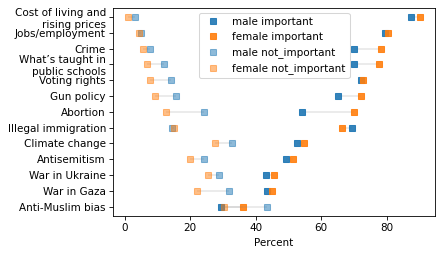

<IPython.core.display.Javascript object>

In [174]:
plot_responses(summary, "important", alpha=0.9)
plot_responses(summary, "not_important", alpha=0.5)
decorate(xlabel="Percent")

One way to interpret these results is to pick the ones with the biggest differences and talk about "wow the differences".
But these differences are often used to tell a story along the lines that men and women are becoming more politically incompatible, so I think it would be useful to quantify what we mean by compatible.

For example, if we imagine a speed-dating service that matches random women and men, and compares their responses, we could define a kind of compatibility score and see how often a hypothetical pair would find themselves disagreeing by too much on to many points.

We could calibrate the results by comparing them with male-male and female-female compatibility.

## Which Party Better Job

This section explores responses to a set of questions based on this schema:

>Please tell us which political party— the [Democrats/Republicans] or the [Republicans/Democrats]—would do a better job handling each of the following issues, or is there no difference.

In [175]:
columns = find_columns(sample, "own_")

<IPython.core.display.Javascript object>

In [176]:
issue_names = {
    "own_immig": "Illegal immigration",
    "own_jobs": "Jobs/employment",
    "own_costliv": "Cost of living and\nrising prices",
    "own_climate": "Climate change",
    "own_abort": "Abortion",
    "own_gun": "Gun policy",
    "own_crime": "Crime",
    "own_gaza": "War in Gaza",
    "own_antisem": "Antisemitism",
    "own_votright": "Voting rights",
    "own_ukraine": "War in Ukraine",
    "own_schteach": "What’s taught in\npublic schools",
    "own_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

The codebook for these variables is not consistent with the data, but it looks like

```
1. Democrats
2. Republicans
3. No difference
```

In [177]:
value_counts(sample["own_immig"])

,counts
values,
1.0,612
2.0,814
3.0,483


<IPython.core.display.Javascript object>

In [178]:
columns = issue_names.keys()
counts = normalized_counts(sample, columns)
counts

,own_immig,own_jobs,own_costliv,own_climate,own_abort,own_gun,own_crime,own_gaza,own_antisem,own_votright,own_ukraine,own_schteach,own_islamop
-7.0,0.000000,0.000000,0.000000,0.000000,0.000524,0.000000,0.000000,0.000000,0.000000,0.000000,0.001048,0.000000,0.001048
1.0,0.320587,0.354636,0.319015,0.446307,0.452069,0.399686,0.272394,0.266108,0.323730,0.408591,0.353064,0.369303,0.372970
2.0,0.426401,0.384494,0.385542,0.202724,0.283394,0.357779,0.382923,0.299633,0.259298,0.282871,0.275013,0.350969,0.180723
3.0,0.253012,0.260870,0.295443,0.350969,0.264013,0.242535,0.344683,0.434259,0.416972,0.308539,0.370875,0.279728,0.445259


<IPython.core.display.Javascript object>

Most people answered all 13 questions, but a few answered 12 or 11.

In [179]:
data = sample[columns].replace(-7, np.nan)
count = data.count(axis=1)
value_counts(count)

,counts
values,
12,5
13,1904


<IPython.core.display.Javascript object>

For each respondents, we add up the fraction of responses in each of the three categories, and the party they were more favorable toward. 

In [180]:
sample["dem"] = (data == 1).sum(axis=1) / count
sample["rep"] = (data == 2).sum(axis=1) / count
sample["same"] = (data == 3).sum(axis=1) / count

sample["pref"] = "same"
sample.loc[sample["dem"] > sample["rep"], "pref"] = "dem"
sample.loc[sample["rep"] > sample["dem"], "pref"] = "rep"

sample[["dem", "rep", "same", "pref"]].head()

,dem,rep,same,pref
1050,0.000000,0.615385,0.384615,rep
455,0.307692,0.692308,0.000000,rep
1364,0.384615,0.230769,0.384615,dem
1650,0.000000,0.846154,0.153846,rep
205,0.846154,0.000000,0.153846,dem


<IPython.core.display.Javascript object>

In [181]:
value_counts(sample["pref"])

,counts
values,
dem,897
rep,772
same,240


<IPython.core.display.Javascript object>

People who identify as Democrats are more likely to think the Democratic party handles these issues better, and people who identify as Republican are more likely to think the Republican party does -- but there are some exceptions in both directions, which might reflect data quality problems.

In [182]:
pd.crosstab(sample["pid"], sample["pref"])

pref,dem,rep,same
pid,,,
1.0,635,32,44
2.0,17,471,29
3.0,245,269,167


<IPython.core.display.Javascript object>

Here's the distribution of partisanship.

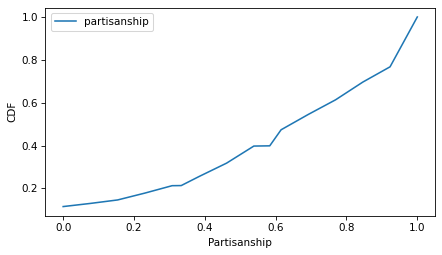

<IPython.core.display.Javascript object>

In [183]:
from empiricaldist import Cdf

sample["partisanship"] = sample[["dem", "rep"]].max(axis=1)
Cdf.from_seq(sample["partisanship"]).plot(label="partisanship")
decorate(xlabel="Partisanship", ylabel="CDF")

A score of 0 means the respondent said "same" to every questions. A score of 1 means they said that one party or the other handles every issue better.

In [184]:
sample_male = sample.query("gender == 1")
sample_female = sample.query("gender == 2")

<IPython.core.display.Javascript object>

Men are more partisan than women.

In [185]:
sample.groupby("gender")["partisanship"].mean()

gender
1.0    0.676102
2.0    0.582154
Name: partisanship, dtype: float64

<IPython.core.display.Javascript object>

If we break it down by gender and party identification, republicans are more partisan than democrats, independent/other are less partisan than both.


In [186]:
tab = sample.pivot_table(
    index="gender",
    columns="pid",
    values="partisanship",
    aggfunc="mean",
    margins=True,
)
tab.columns = ["dem", "rep", "ind/other", "all"]
tab.index = ["male", "female", "all"]
tab

,dem,rep,ind/other,all
male,0.725253,0.773020,0.551479,0.676102
female,0.664747,0.683476,0.418539,0.582154
all,0.693426,0.726256,0.481984,0.626889


<IPython.core.display.Javascript object>

Here are responses to "Some people don’t pay much attention to political campaigns.
How about you? Would you say that you have been [very much interested, somewhat
interested or not much interested/ not much interested, somewhat interested or very
much interested] in the political campaigns so far this year?"

```
1. Very much interested
2. Somewhat interested
3. Not much interested
```

In [187]:
value_counts(sample["follow_campinterest"])

,counts
values,
1.0,790
2.0,711
3.0,408


<IPython.core.display.Javascript object>

People who follow more closely are more partisan. The arrow of causation could go both ways there.

In [188]:
pd.crosstab(sample["gender"], sample["follow_campinterest"], normalize="index")

follow_campinterest,1.0,2.0,3.0
gender,,,
1.0,0.510451,0.355336,0.134213
2.0,0.326000,0.388000,0.286000


<IPython.core.display.Javascript object>

In [189]:
tab = sample.pivot_table(
    index="gender",
    columns="follow_campinterest",
    values="partisanship",
    aggfunc="mean",
    margins=True,
)
tab.columns = ["very", "somewhat", "not much", "all"]
tab.index = ["male", "female", "all"]
tab

,very,somewhat,not much,all
male,0.761660,0.649004,0.422446,0.676102
female,0.780557,0.600912,0.330554,0.582154
all,0.769458,0.622760,0.358032,0.626889


<IPython.core.display.Javascript object>

## Regression models

To put it all together, we'll run some regressions with partisanship as the dependent variable.

In [190]:
from statsmodels.iolib.table import SimpleTable


def display_summary(result):
    """Prints summary statistics from a regression model.

    result: RegressionResults object
    """
    params = result.summary().tables[1]
    display(params)

    if hasattr(result, "rsquared"):
        row = ["R-squared:", f"{result.rsquared:0.4}"]
    elif hasattr(result, "prsquared"):
        row = ["Pseudo R-squared:", f"{result.prsquared:0.4}"]
    else:
        return
    table = SimpleTable([row])
    display(table)

<IPython.core.display.Javascript object>

Women are less partisan.

In [191]:
import statsmodels.formula.api as smf

model = smf.ols('partisanship ~ C(gender)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6761,0.011,61.744,0.000,0.655,0.698
C(gender)[T.2.0],-0.0939,0.015,-6.210,0.000,-0.124,-0.064


R-squared:,0.01982


<IPython.core.display.Javascript object>

Controlling for gender, republicans are (still) more partisan, independent/other are less.

In [192]:
import statsmodels.formula.api as smf

model = smf.ols('partisanship ~ C(gender) + C(pid)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7430,0.014,53.439,0.000,0.716,0.770
C(gender)[T.2.0],-0.0942,0.014,-6.592,0.000,-0.122,-0.066
C(pid)[T.2.0],0.0325,0.018,1.802,0.072,-0.003,0.068
C(pid)[T.3.0],-0.2117,0.017,-12.663,0.000,-0.245,-0.179


R-squared:,0.1263


<IPython.core.display.Javascript object>

Controlling for level of interest in the campaign, the gender gap is cut by more than half.

I'd suggest that interest level is a mediator here -- part of the reason men are more partisan is that they follow the campaign more closely.

In [193]:
model = smf.ols('partisanship ~ C(gender) + C(pid) + C(follow_campinterest)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8272,0.014,57.723,0.000,0.799,0.855
C(gender)[T.2.0],-0.0354,0.013,-2.647,0.008,-0.062,-0.009
C(pid)[T.2.0],0.0151,0.016,0.919,0.358,-0.017,0.047
C(pid)[T.3.0],-0.1662,0.015,-10.762,0.000,-0.196,-0.136
C(follow_campinterest)[T.2.0],-0.1341,0.015,-9.033,0.000,-0.163,-0.105
C(follow_campinterest)[T.3.0],-0.3587,0.018,-19.807,0.000,-0.394,-0.323


R-squared:,0.2758


<IPython.core.display.Javascript object>

## Plotting the results

In [194]:
data_male = sample_male[columns].replace(-7, np.nan)
data_female = sample_female[columns].replace(-7, np.nan)

<IPython.core.display.Javascript object>

In [195]:
slice_map = dict(democrats=slice(1, 1), republicans=slice(2, 2), same=slice(3, 3))
summary = summarize_responses(columns, slice_map, sort_idx=2)
summary

male                           female              \
              democrats republicans       same democrats republicans   
own_gun       40.924092   39.933993  19.141914  39.10000   32.000000   
own_abort     46.145374   30.837004  23.017621  44.40000   26.100000   
own_immig     33.003300   46.644664  20.352035  31.20000   39.000000   
own_jobs      39.383938   41.584158  19.031903  31.90000   35.600000   
own_schteach  37.953795   40.264026  21.782178  36.00000   30.400000   
own_costliv   33.663366   41.914191  24.422442  30.30000   35.500000   
own_votright  44.774477   32.013201  23.212321  37.30000   24.900000   
own_crime     27.612761   42.134213  30.253025  26.90000   34.800000   
own_climate   46.644664   24.532453  28.822882  42.80000   16.400000   
own_ukraine   38.393839   32.453245  29.152915  32.56513   23.046092   
own_antisem   32.783278   29.922992  37.293729  32.00000   22.300000   
own_gaza      28.162816   32.673267  39.163916  25.20000   27.500000   
own_islamop   37.706725   20.837927  41.455347  37.00000   15.600000   

                         
                   same  
own_gun       28.900000  
own_abort     29.500000  
own_immig     29.800000  
own_jobs      32.500000  
own_schteach  33.600000  
own_costliv   34.200000  
own_votright  37.800000  
own_crime     38.300000  
own_climate   40.800000  
own_ukraine   44.388778  
own_antisem   45.700000  
own_gaza      47.300000  
own_islamop   47.400000

<IPython.core.display.Javascript object>

In [196]:
names = [issue_names[col] for col in summary.index]

<IPython.core.display.Javascript object>

For every issue, men are more likely to say that the Republicans handle it better.

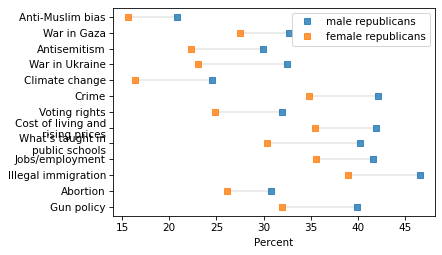

<IPython.core.display.Javascript object>

In [198]:
plot_responses(summary, "republicans")
decorate(xlabel="Percent")

But they are also more likely to say that Democrats handle it better.

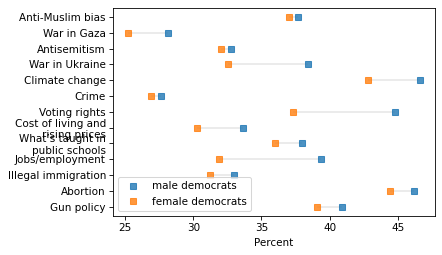

<IPython.core.display.Javascript object>

In [197]:
plot_responses(summary, "democrats")
decorate(xlabel="Percent")

Because they are less likely to say that they are about the same.

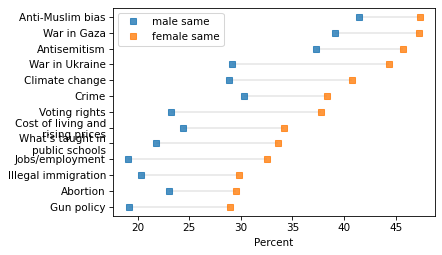

<IPython.core.display.Javascript object>

In [199]:
plot_responses(summary, "same")
decorate(xlabel="Percent")

Let's run some regressions with number of "same" as the dependent variable.

In [203]:
sample["y"] = (sample[columns] == 3).sum(axis=1)
sample.groupby("gender")["y"].mean()

gender
1.0    3.569857
2.0    4.901000
Name: y, dtype: float64

<IPython.core.display.Javascript object>

The difference in means is 1.33

In [205]:
model = smf.ols('y ~ C(gender)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.5699,0.142,25.163,0.000,3.292,3.848
C(gender)[T.2.0],1.3311,0.196,6.791,0.000,0.947,1.716


R-squared:,0.02361


<IPython.core.display.Javascript object>

Part of that is "explained" by party id: women are less likely to identify as Republican, and  Republicans are less likely to say "same".

In [204]:
model = smf.ols('y ~ C(gender) + C(pid)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7383,0.187,9.278,0.000,1.371,2.106
C(gender)[T.2.0],0.6141,0.175,3.517,0.000,0.272,0.957
C(pid)[T.2.0],-0.1468,0.215,-0.682,0.495,-0.569,0.275
C(pid)[T.3.0],2.1882,0.202,10.840,0.000,1.792,2.584
C(follow_campinterest)[T.2.0],1.3855,0.194,7.140,0.000,1.005,1.766
C(follow_campinterest)[T.3.0],4.4460,0.237,18.777,0.000,3.982,4.910


R-squared:,0.2653


<IPython.core.display.Javascript object>

And a little bit more is explained by following the campaign: women are less likely to follow, and people who follow are less likely to say "same" -- in fact, people who are "not much interested" say "same" much more -- the difference is 4.5.

In [204]:
model = smf.ols('y ~ C(gender) + C(pid) + C(follow_campinterest)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7383,0.187,9.278,0.000,1.371,2.106
C(gender)[T.2.0],0.6141,0.175,3.517,0.000,0.272,0.957
C(pid)[T.2.0],-0.1468,0.215,-0.682,0.495,-0.569,0.275
C(pid)[T.3.0],2.1882,0.202,10.840,0.000,1.792,2.584
C(follow_campinterest)[T.2.0],1.3855,0.194,7.140,0.000,1.005,1.766
C(follow_campinterest)[T.3.0],4.4460,0.237,18.777,0.000,3.982,4.910


R-squared:,0.2653


<IPython.core.display.Javascript object>

## Group Ratings

This section explores reponses to questions that follow this schema:

> We would like to get your feelings toward some of our political leaders
and other people who are in the news these days. We will show the name of a person
and we’d like you to rate that person using something we call the feeling thermometer.
Ratings between 50 degrees and 100 degrees mean that you feel favorable and warm
toward the person. Ratings between 0 degrees and 50 degrees mean that you don’t feel
favorable toward the person and that you don’t care too much for that person. You
would rate the person at the 50 degree mark if you don’t feel particularly warm or cold
toward the person.
If we come to a person whose name you don’t recognize, you don’t need to rate that
person. Just click ’Next’ and we’ll move on to the next one.

In [206]:
columns = find_columns(sample, "cand_")
columns

['cand_trump', 'cand_biden']

<IPython.core.display.Javascript object>

In [207]:
sample[columns].replace(-7, np.nan).describe()

,cand_trump,cand_biden
count,1907.000000,1905.000000
mean,42.628736,42.544882
std,39.203930,36.760156
min,0.000000,0.000000
25%,1.000000,2.000000
50%,40.000000,41.000000
75%,84.000000,75.000000
max,100.000000,100.000000


<IPython.core.display.Javascript object>

In [208]:
sample_male = sample.query("gender == 1").replace(-7, np.nan)
sample_female = sample.query("gender == 2").replace(-7, np.nan)
len(sample_male), len(sample_female)

(909, 1000)

<IPython.core.display.Javascript object>

In [209]:
d = dict(male=sample_male[columns].mean(), female=sample_female[columns].mean())
ratings_df = pd.DataFrame(d).sort_values(by="female")
ratings_df

,male,female
cand_trump,45.216722,40.271543
cand_biden,42.903867,42.220000


<IPython.core.display.Javascript object>

In [210]:
def plot_ratings(summary, names):
    plt.hlines(
        names,
        summary["male"],
        summary["female"],
        color="gray",
        alpha=0.2,
    )

    draw_markers(summary['male'], names, 's', label='male')
    draw_markers(summary['female'], names, 'o', label='female')


<IPython.core.display.Javascript object>

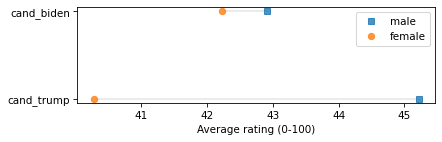

<IPython.core.display.Javascript object>

In [211]:
plt.figure(figsize=(6, 2))
names = ratings_df.index
plot_ratings(ratings_df, names)
decorate(xlabel="Average rating (0-100)")

In [212]:
columns = find_columns(sample, "group_")
columns

['group_maga',
 'group_demsoc',
 'group_fascists',
 'group_kkk',
 'group_nazi',
 'group_blm',
 'group_atheists',
 'group_prolife',
 'group_prochoice',
 'group_gunrights',
 'group_lgbtrights',
 'group_feminists',
 'group_whitesup',
 'group_antigay',
 'group_socialist',
 'group_antifa',
 'group_christfund',
 'group_laborun',
 'group_bigbus',
 'group_gayles',
 'group_transppl',
 'group_christians',
 'group_police',
 'group_journal',
 'group_nra',
 'group_ruralam',
 'group_planparent',
 'group_colprofs',
 'group_black',
 'group_white',
 'group_hispanic',
 'group_asian',
 'group_transmen',
 'group_transwom',
 'group_jews',
 'group_muslims']

<IPython.core.display.Javascript object>

In [213]:
sample[columns].replace(-7, np.nan).describe()

,group_maga,group_demsoc,group_fascists,group_kkk,group_nazi,group_blm,group_atheists,group_prolife,group_prochoice,group_gunrights,...,group_planparent,group_colprofs,group_black,group_white,group_hispanic,group_asian,group_transmen,group_transwom,group_jews,group_muslims
count,1900.000000,1902.000000,1901.000000,1893.000000,1903.000000,1909.000000,1909.000000,1908.000000,1905.000000,1906.000000,...,1909.000000,1905.000000,1909.000000,1907.000000,1909.000000,1908.000000,1908.000000,1909.000000,1909.000000,1909.000000
mean,36.466842,42.864879,17.269858,10.526149,12.376248,46.343112,47.551074,48.323375,55.205774,49.528332,...,56.900471,57.791601,71.162913,70.362349,70.647983,71.623690,44.306080,45.786799,69.691461,55.476166
std,34.430421,33.944863,23.709143,21.519203,21.914428,36.238511,30.101577,33.528060,33.561756,34.221626,...,35.231096,27.966463,25.029211,23.460451,24.335804,23.228531,34.163579,35.035518,25.384024,27.897745
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,0.000000,0.000000,0.000000,3.000000,25.000000,15.000000,29.000000,16.000000,...,26.000000,45.000000,50.000000,51.000000,51.000000,51.000000,7.000000,6.000000,51.000000,43.000000
50%,33.000000,50.000000,3.000000,0.000000,1.000000,50.000000,50.000000,50.000000,53.000000,50.000000,...,61.000000,60.000000,74.000000,71.000000,72.000000,74.000000,50.000000,50.000000,72.000000,53.000000
75%,60.000000,70.000000,30.000000,6.000000,14.000000,78.000000,67.000000,75.000000,86.000000,80.000000,...,89.000000,81.000000,94.000000,90.000000,93.000000,91.000000,71.000000,75.000000,90.000000,76.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


<IPython.core.display.Javascript object>

In [214]:
sample_male = sample.query("gender == 1").replace(-7, np.nan)
sample_female = sample.query("gender == 2").replace(-7, np.nan)
len(sample_male), len(sample_female)

(909, 1000)

<IPython.core.display.Javascript object>

In [215]:
d = dict(male=sample_male[columns].mean(), female=sample_female[columns].mean())
ratings_df = pd.DataFrame(d).sort_values(by="female")
ratings_df

,male,female
group_kkk,13.201111,8.101712
group_nazi,13.027533,11.781910
group_whitesup,17.191630,12.772545
group_fascists,16.914917,17.592369
group_antifa,29.646993,27.469867
group_antigay,27.580858,29.914915
group_maga,39.538803,33.690381
group_socialist,39.321192,39.543544
group_christfund,44.708471,42.558350
group_demsoc,42.199559,43.471357


<IPython.core.display.Javascript object>

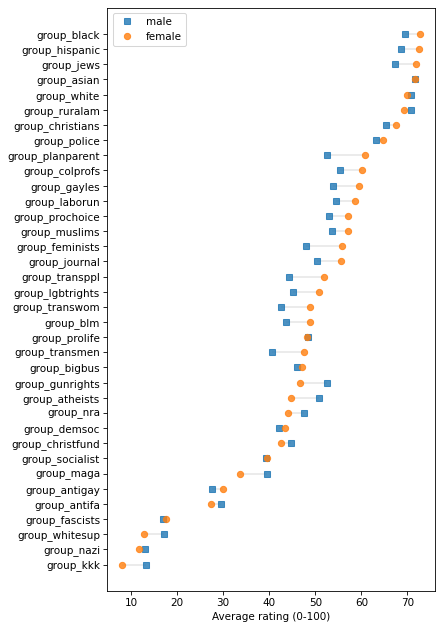

<IPython.core.display.Javascript object>

In [216]:
plt.figure(figsize=(6, 8.5))
names = ratings_df.index
plot_ratings(ratings_df, names)
decorate(xlabel="Average rating (0-100)")

## Look for variables with large gender gaps

This section and the next contain two methods for identifying questions with large gender gaps, without bothering to decode the responses.

Method 1 looks for variables where there's a big difference in the means, but it might not be reliable because a lot of variables are encoded in a way where the mean is not meaningful (or it's misleading).
But it's a way to find candidates.

Method 2 finds t

In [246]:
def compute_diff_means(col, flag):
    male = df_male[col].dropna()
    try:
        male = male.where(male >= 0, np.nan)
    except TypeError:
        return np.nan

    female = df_female[col].dropna()
    female = female.where(female >= 0, np.nan)

    if male.count() == 0 or female.count() == 0:
        return np.nan

    m1, m2 = male.mean(), female.mean()
    avg = (m1 + m2) / 2
    return (m1 - m2) / avg

<IPython.core.display.Javascript object>

In [247]:
df_male = sample.query("gender == 1")
df_female = sample.query("gender == 2")
len(df_male), len(df_female)

(909, 1000)

<IPython.core.display.Javascript object>

In [248]:
df_male.dtypes

version          object
caseid            int16
weight          float64
weight_spss     float32
sample_type     float64
                 ...   
rep             float64
same            float64
pref             object
partisanship    float64
y                 int64
Length: 948, dtype: object

<IPython.core.display.Javascript object>

In [260]:
candidate_cols = [
    col for col in df.columns if not col.endswith("timing") and not col.endswith("skp")
]

<IPython.core.display.Javascript object>

In [261]:
res = []
for col in candidate_cols:
    diff1 = compute_diff_means(col, True)
    diff2 = compute_diff_means(col, False)
    res.append((col, diff1, diff2))

<IPython.core.display.Javascript object>

In [262]:
columns = ["varname", "diff1", "diff2"]
diff_df = pd.DataFrame(res, columns=columns).dropna()

<IPython.core.display.Javascript object>

In [263]:
diff1 = diff_df["diff1"]
diff2 = diff_df["diff2"]
diff_df["absdiff"] = np.maximum(diff_df["diff1"].abs(), diff_df["diff2"].abs())

<IPython.core.display.Javascript object>

In [264]:
candidates = diff_df.sort_values(by="absdiff", ascending=False)
candidates.index = candidates["varname"]
candidates = candidates.drop(columns=["varname"]) * 100
candidates.head(50)

,diff1,diff2,absdiff
varname,,,
gendid_masc,112.619442,112.619442,112.619442
gendid_fem,-107.979407,-107.979407,107.979407
gendid_mascfem,-85.559458,-85.559458,85.559458
gender,-66.666667,-66.666667,66.666667
gender4,-63.143464,-63.143464,63.143464
group_kkk,47.875337,47.875337,47.875337
rrace_resp_Eastern,34.482759,34.482759,34.482759
religpew_protestant,34.144250,34.144250,34.144250
group_whitesup,29.495789,29.495789,29.495789


<IPython.core.display.Javascript object>

In [265]:
candidates.to_csv("anes_2024_candidates_resampled.csv")

<IPython.core.display.Javascript object>

If you find a candidate, you can look more closely with `compare_responses`.

In [266]:
def compare_responses(varname):
    d = dict(
        male=value_counts(df_male[varname], normalize=True)["counts"],
        female=value_counts(df_female[varname], normalize=True)["counts"],
    )
    summary = pd.DataFrame(d)
    summary["diff"] = summary["male"] - summary["female"]
    summary["absdiff"] = summary["diff"].abs()
    return summary

<IPython.core.display.Javascript object>

In [267]:
compare_responses("pew_prayer") * 100

,male,female,diff,absdiff
values,,,,
1.0,20.682068,30.5,-9.817932,9.817932
2.0,16.061606,16.0,0.061606,0.061606
3.0,12.651265,11.3,1.351265,1.351265
4.0,4.180418,2.7,1.480418,1.480418
5.0,5.280528,6.3,-1.019472,1.019472
6.0,13.751375,12.3,1.451375,1.451375
7.0,24.422442,16.1,8.322442,8.322442
8.0,2.970297,4.8,-1.829703,1.829703


<IPython.core.display.Javascript object>

## Look for differences

Another way to look for differences, but finding the most common response to a question and then comparing the fractions who give that response.

In [268]:
def compute_diff(col):
    value = sample[col].value_counts().idxmax()

    male = df_male[col].dropna().value_counts()
    female = df_female[col].dropna().value_counts()

    p_male = male.get(value, 0) / male.sum()
    p_female = female.get(value, 0) / female.sum()
    return p_male - p_female

<IPython.core.display.Javascript object>

In [269]:
res = []
for col in candidate_cols:
    diff = compute_diff(col)
    res.append((col, diff))

<IPython.core.display.Javascript object>

In [270]:
columns = ["varname", "diff"]
diff_df = pd.DataFrame(res, columns=columns).dropna()
diff_df["absdiff"] = diff_df["diff"].abs()

<IPython.core.display.Javascript object>

In [271]:
candidates = diff_df.sort_values(by="absdiff", ascending=False)
candidates.index = candidates["varname"]
candidates = candidates.drop(columns=["varname"]) * 100
candidates.head(50)

,diff,absdiff
varname,,
gender,-100.000000,100.000000
gender4,-96.929923,96.929923
gendid_masc,-43.029813,43.029813
gendid_fem,40.754345,40.754345
gendid_mascfem,-38.419912,38.419912
disqual_sexhar,-20.605171,20.605171
follow_campinterest,18.445105,18.445105
aid_israel,-17.717822,17.717822
newsint,17.285259,17.285259


<IPython.core.display.Javascript object>

In [ ]:
candidates.to_csv("anes_2024_candidates_resampled.csv")